# Colour Spaces

## Initialization

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.colors import NoNorm

In [3]:
# convenience function that estimates the difference between 2 images
def diffscore(img1, img2):
    return np.sum(abs(img1-img2))

# convenience function to draw 1 image - no typing 4 lines anymore
def display(img):
    plt.figure()
    plt.axis("off")
    if len(img.shape) < 3:
        plt.imshow(img,cmap='gray',norm=NoNorm())
        # this ensures plt doesn't treat our grayscale array as a messed-up 3-channel image
    else:
        plt.imshow(img)
    plt.show()

In [4]:
src = cv2.cvtColor(cv2.imread("src.jpg"), cv2.COLOR_BGR2RGB)

## Different representations

We have so far considered all images in RGB:

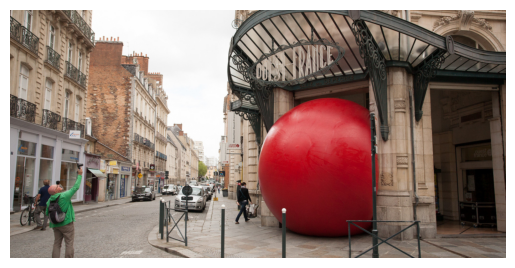

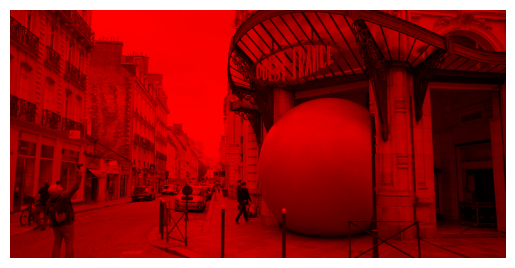

In [5]:
display(src)
r = src[:,:,0] #<- array at channel 0
display(np.stack([r, np.zeros_like(r), np.zeros_like(r)], axis=2))

However, cv2 by default reads images as BGR. If we try to display the original with plt, we get a messed up scheme:

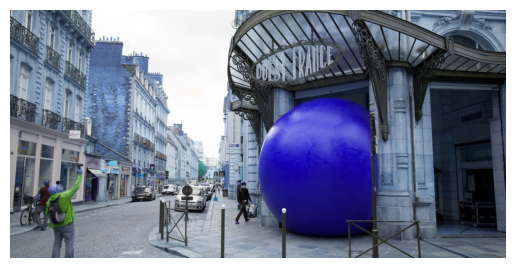

In [6]:
display(cv2.imread('src.jpg'))

Note how green is in the same channel, so the clothing of the photographer on the left stays almost unchanged.

Of course, converting BGR to RGB is trivial. What about HSI/HSV? (The 2 are not exactly the same, but both along with HLS follow the same general idea and have the same upsides/drawbacks)

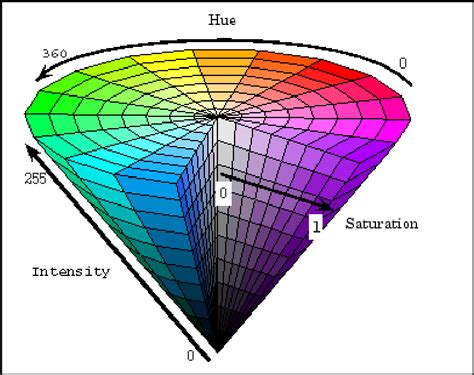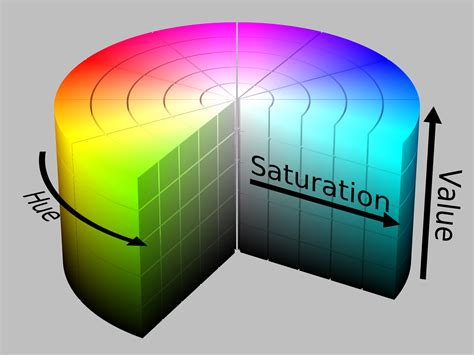

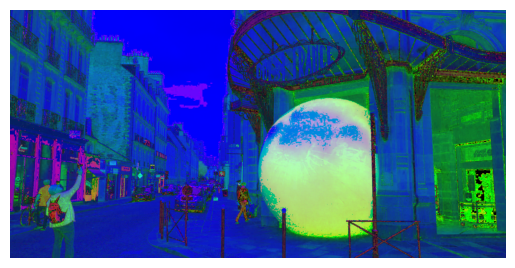

In [7]:
src_hsv = cv2.cvtColor(src, cv2.COLOR_RGB2HSV)
display(src_hsv)

HSV is gibberish to a human observer, but it is better for detecting colors within an algorithm

Here's a showcase of HSV range. Note the looping over, it happens since int8 cannot encode 360 degrees, so that range is compressed to 0-179 degrees

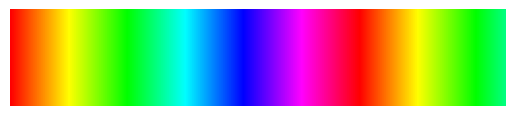

In [8]:
byterange = np.array([[x for x in range(0,256)] for _ in range(50)], dtype=np.uint8)
test = np.stack([byterange,np.full_like(byterange, 255),np.full_like(byterange, 255)], axis=2) #(byterange, 0)) white / (byterange, 0) black (byterange, 127) middle of the pie
test = cv2.cvtColor(test, cv2.COLOR_HSV2RGB)
display(test)

#### Color Thresholding, bad version (30 points, because it ain't that easy)
Detect the giant red ball on the RGB image: most of it must be white (along with any other red objects), and the rest of the image black (or vice versa). With that mask you can paint out the background

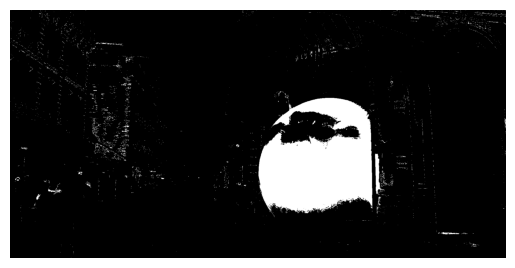

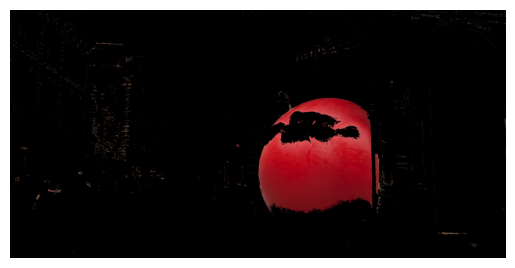

In [9]:
mask = src[:,:,0] > 110

mask2 = src[:,:,1] < 90

mask3 = src[:,:,2] < 90

maskop = np.bitwise_and(mask, mask2)
mask = np.bitwise_and(maskop, mask3)

display (np.where (mask, 255, 0))

r = np.where(mask, src[:,:,0],0)
g = np.where(mask, src[:,:,1],0)
b = np.where(mask, src[:,:,2],0)
display(np.stack([r,g,b],axis=2))

#### Color Thresholding, good version (14 points)
Detect the giant red ball on the HSV image

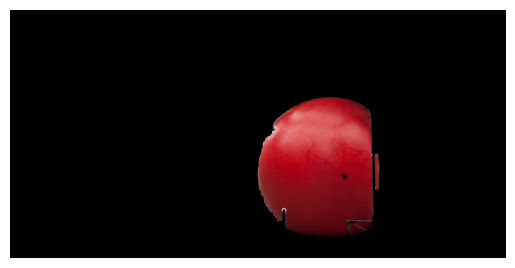

In [10]:
mask_1 = src_hsv[:,:,0] < 3
mask_2 = src_hsv[:,:,0] > 175
mask = np.bitwise_or(mask_1, mask_2)

mask_s = src_hsv[:,:,1] > 30
mask_v =  src_hsv[:,:,2] > 10

maskop = np.bitwise_and(mask, mask_s)
mask = np.bitwise_and(maskop, mask_v)

#if it was a detecting an object task erode can be done to remove extra noise
mask = np.where(mask, 255, 0).astype(np.uint8)
mask = cv2.erode(mask, np.full((9,9),1)) #removing small noise
mask = cv2.dilate(mask, np.full((15,15),1)) #engancing the ball shape (that was eroded mistakenly)

r = np.where(mask, src[:,:,0], 0)
g = np.where(mask, src[:,:,1], 0)
b = np.where(mask, src[:,:,2], 0)
display(np.stack([r,g,b],axis=2))

#### Color Thresholding, best version (10 points)
There's also a more precise option, cv2.inRange(src, point1, point2). Use it to detect the ball on the HSV image with fewer artifacts.

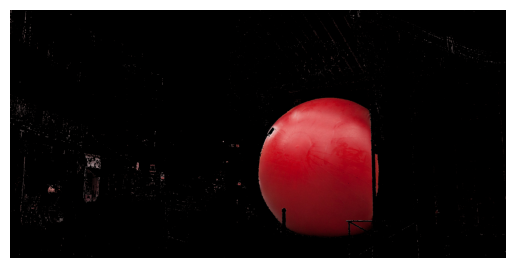

In [11]:
mask1 = cv2.inRange(src_hsv, (175,30,10), (179,255,255))
mask2 = cv2.inRange(src_hsv, (0,30,10), (3,255,255))
mask = np.bitwise_or(mask1, mask2)

r = np.where(mask, src[:,:,0], 0)
g = np.where(mask, src[:,:,1], 0)
b = np.where(mask, src[:,:,2], 0)
display(np.stack([r,g,b],axis=2))

## Homework

#### Where in range? (10 points)
Implement some analogue to the cv2.inRange function. You can use np.where(). *Hint: you can multiply or add masks to simulate logical OR and AND*

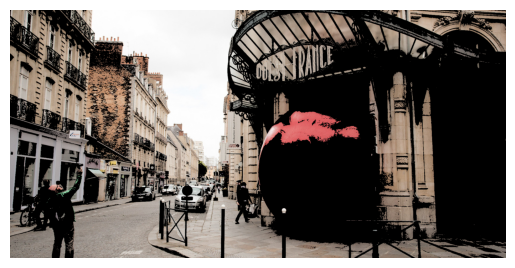

In [12]:
def inRange(img, lower, upper):
    mask1 = np.where((img[:,:,0] >= lower[0]) & (img[:,:,0] <= upper[0]), 1, 0).astype(np.uint8)
    mask2 = np.where((img[:,:,1] >= lower[1]) & (img[:,:,1] <= upper[1]), 1, 0).astype(np.uint8)
    mask3 = np.where((img[:,:,2] >= lower[2]) & (img[:,:,2] <= upper[2]), 1, 0).astype(np.uint8)
    mask = np.bitwise_and(mask1, mask2)
    mask = np.bitwise_and(mask, mask3)
    return mask

lower = np.array([110, 90, 90])
upper = np.array([255, 255, 255])
mask = inRange(src, lower, upper)
r = np.where(mask, src[:,:,0], 0)
g = np.where(mask, src[:,:,1], 0)
b = np.where(mask, src[:,:,2], 0)
display(np.stack([r,g,b],axis=2))

#### Color maths (18+18 points)
Implement functions to convert RGB to a circular colorspace and vice versa. I suggest HSV, HSI, or HLS, since you are free to search for formulas online and those are the most popular. Half the points for RGB to XXX function, half for the reverse one.

C:\Users\Nikita\AppData\Local\Temp\ipykernel_13524\3159769817.py:9: RuntimeWarning: invalid value encountered in divide
  hue[max_vals == 0] = (g[max_vals == 0] - b[max_vals == 0]) / delta[max_vals == 0]
C:\Users\Nikita\AppData\Local\Temp\ipykernel_13524\3159769817.py:13: RuntimeWarning: invalid value encountered in divide
  saturation = np.where(maxes == 0, 0, delta / maxes)


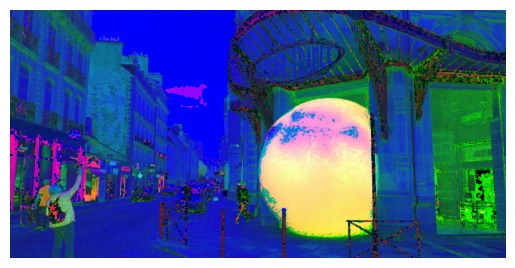

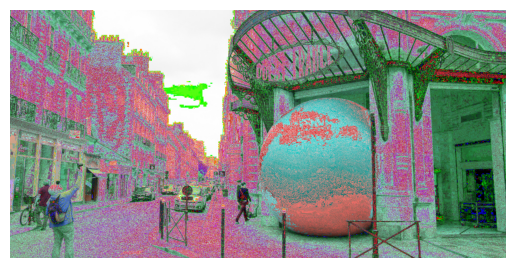

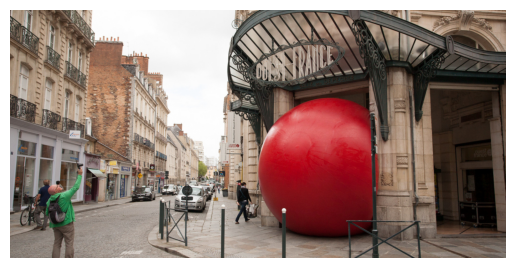

In [90]:
def rgb_2_hsv(img):
    r, g, b = img[..., 0] / 255, img[..., 1] / 255, img[..., 2] / 255
    max_vals = np.argmax(np.array([r,g,b]), axis=0)
    min_vals = np.argmin(np.array([r,g,b]), axis=0)
    maxes = np.choose(max_vals, np.array([r,g,b]))
    mins = np.choose(min_vals, np.array([r,g,b]))
    delta = maxes - mins
    hue = np.zeros_like(r)
    hue[max_vals == 0] = (g[max_vals == 0] - b[max_vals == 0]) / delta[max_vals == 0]
    hue[max_vals == 1] = 2 + (b[max_vals == 1] - r[max_vals == 1]) / delta[max_vals == 1]
    hue[max_vals == 2] = 4 + (r[max_vals == 2] - g[max_vals == 2]) / delta[max_vals == 2]
    hue = hue / 6.0 % 1.0
    saturation = np.where(maxes == 0, 0, delta / maxes)
    value = maxes
    hsv = np.dstack((hue, saturation, value))
    return hsv

def hsv_2_rgb(img):
    h, s, v = img[..., 0], img[..., 1], img[..., 2]
    c = v * s
    x = c * (1 - np.abs((h / 60) % 2 - 1))
    m = v - c
    img_mod = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if h[i][j] < 60:
                img_mod[i][j] = np.array([c[i][j], x[i][j], 0])
            elif h[i][j] < 120:
                img_mod[i][j] = np.array([x[i][j], c[i][j], 0])
            elif h[i][j] < 180:
                img_mod[i][j] = np.array([0, c[i][j], x[i][j]])
            elif h[i][j] < 240:
                img_mod[i][j] = np.array([0, x[i][j], c[i][j]])
            elif h[i][j] < 300:
                img_mod[i][j] = np.array([x[i][j], 0, c[i][j]])
            else:
                img_mod[i][j] = np.array([c[i][j], 0, x[i][j]])
            img_mod[i][j] += m[i][j]
            #img_mod[i][j] *= 255
            #img_mod[i,j] = (img_mod[i,j]+m[i,j]) * 255
    return img_mod


display(rgb_2_hsv(src))
display(hsv_2_rgb(cv2.cvtColor(src, cv2.COLOR_RGB2HSV)))
display(cv2.cvtColor(cv2.cvtColor(src, cv2.COLOR_RGB2HSV), cv2.COLOR_HSV2RGB))